## Setup

In [1]:
# =============================================================================
# |                                IMPORTS                                    | 
# =============================================================================
from types import MethodType

import torch
from diffusers import StableDiffusionControlNetPipeline, DDIMScheduler, AutoencoderKL, ControlNetModel
from diffusers import StableDiffusionControlNetInpaintPipeline, StableDiffusionPipeline, StableDiffusionInpaintPipelineLegacy
# from diffusers import StableDiffusionXLControlNetInpaintPipeline
from pipeline_controlnet_inpaint_sd_xl import StableDiffusionXLControlNetInpaintPipeline
from PIL import Image, ImageChops

from ip_adapter import IPAdapter
from ip_adapter.utils import register_cross_attention_hook # ?

from rembg import remove
import os
import numpy as np
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# =============================================================================
# |                                PATHS                                      | 
# =============================================================================
root_path = "/media/raid/santiagojn/IPAdapter/"
base_model_path = root_path + "stable-diffusion-v1-5"
vae_model_path = root_path + "sd-vae-ft-mse"
use_custom = True
if use_custom:
    image_encoder_path = root_path + "image_encoders/factor_serrano_test102_ghostsaugm"
    ip_ckpt = root_path + "results/test_masked-ghosts_2/checkpoint-500/ip_adapter.bin"
else:
    image_encoder_path = root_path + "models/image_encoder"
    ip_ckpt = root_path + "models/ip-adapter_sd15.bin"
    # ip_ckpt = root_path + "results/finetune_IPA_ghosts/checkpoint-200/ip_adapter.bin"
device = "cuda"

# =============================================================================
# |                                 DEFS                                      | 
# =============================================================================
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)

vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=torch.float16)

/home/santiagojn/anaconda3/envs/ipa/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/santiagojn/anaconda3/envs/ipa/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


## Image variations

Quizás no saca buenas image variations, porque se supone que usa solo la info del embedding en 7~8 latents.

In [2]:
# load SD pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading pipeline components...: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


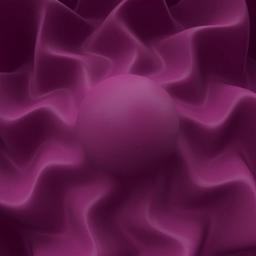

In [3]:
# read image prompt
image = Image.open("assets/images/havran_pink.png")
image.resize((256, 256))

In [4]:
# load ip-adapter
ip_model = IPAdapter(pipe, image_encoder_path, ip_ckpt, device, custom_FVAE=use_custom)

[WARNING] Selecting the following dimensions as relevant.
Make sure this is correct before using them
[ 3  6  7 11 13 17 19]


In [5]:
# generate image variations
images = ip_model.generate(pil_image=image, num_samples=4, num_inference_steps=50, seed=42
            )
grid = image_grid(images, 2,2)
grid

Image embeds: torch.Size([1, 20])
After filtering the relevant dimensions: torch.Size([1, 7])
Calling proj model with image embeds
---FORWARD---
Calling proj model with zeros
---FORWARD---
Default IPAdapter generate, image_prompt_embeds: torch.Size([1, 4, 768])
Concatenating prompt_embeds_ with shape torch.Size([4, 77, 768]), and image_prompt_embeds with shape torch.Size([4, 4, 768])


 12%|█▏        | 6/50 [00:02<00:18,  2.38it/s]


KeyboardInterrupt: 

## Inpainting SD

In [7]:
# load SD Inpainting pipe
#del pipe, ip_model
torch.cuda.empty_cache()
pipe = StableDiffusionInpaintPipelineLegacy.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00,  5.56it/s]
/home/santiagojn/anaconda3/envs/ipa/lib/python3.8/site-packages/diffusers/pipelines/deprecated/stable_diffusion_variants/pipeline_stable_diffusion_inpaint_legacy.py:141: FutureWarning: The class <class 'diffusers.pipelines.deprecated.stable_diffusion_variants.pipeline_stable_diffusion_inpaint_legacy.StableDiffusionInpaintPipelineLegacy'> is deprecated and will be removed in v1.0.0. You can achieve exactly the same functionalityby loading your model into `StableDiffusionInpaintPipeline` instead. See https://github.com/huggingface/diffusers/pull/3533for more information.
  deprecate("legacy is outdated", "1.0.0", deprecation_message, standard_warn=False)
You have disabled the safety checker for <class 'diffusers.pipelines.deprecated.stable_diffusion_variants.pipeline_stable_diffusion_inpaint_legacy.StableDiffusionInpaintPipelineLegacy'> by passing `safety_checker=None`. Ensure that you abide to the conditions o

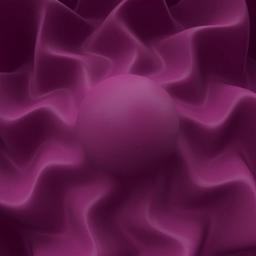

In [8]:
# Image used to condition material of the generated sample
image = Image.open("assets/images/havran_pink.png")
image.resize((256, 256))

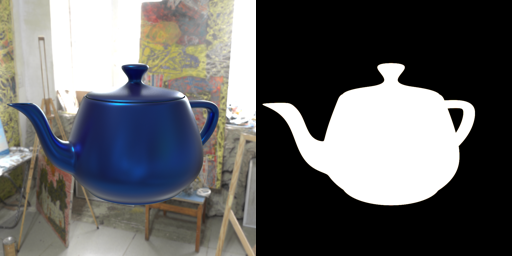

In [9]:
masked_image = Image.open("assets/inpainting/teapot_image.png").resize((256, 256))
mask = Image.open("assets/inpainting/teapot_mask.png").resize((256, 256))
image_grid([masked_image.resize((256, 256)), mask.resize((256, 256))], 1, 2)

In [10]:
# load ip-adapter
ip_model = IPAdapter(pipe, image_encoder_path, ip_ckpt, device, custom_FVAE=use_custom)

[WARNING] Selecting the following dimensions as relevant.
Make sure this is correct before using them
[ 3  6  7 11 13 17 19]


Image embeds: tensor([[ 1.2422,  0.1237, -0.0672, -0.2688, -0.0219,  0.1058, -0.9229,  0.7954,
         -0.0576, -0.1271, -0.1289,  0.3335,  0.1444,  0.2145, -0.0822,  0.0366,
          0.0767, -1.1387, -0.0133, -1.2393]], device='cuda:0',
       dtype=torch.float16)
After filtering the relevant dimensions ([ 3  6  7 11 13 17 19]): tensor([[-0.2688, -0.9229,  0.7954,  0.3335,  0.2145, -1.1387, -1.2393]],
       device='cuda:0', dtype=torch.float16)


  0%|          | 0/29 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 18.47it/s]


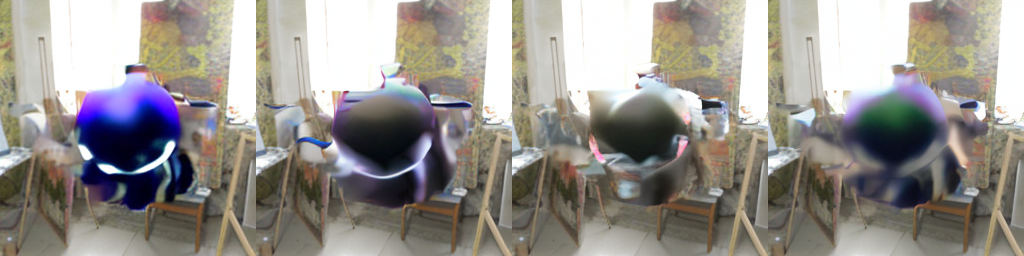

In [11]:
# generate
images = ip_model.generate(pil_image=image, num_samples=4, num_inference_steps=30, seed=42,
                            image=masked_image, mask_image=mask, strength=0.99, )
grid = image_grid(images, 1, 4)
grid

## ControlNet **Inpainting** ✅

In [12]:
# load controlnet
controlnet_model_path = root_path + "control_v11p_sd15_inpaint"
controlnet = ControlNetModel.from_pretrained(controlnet_model_path, torch_dtype=torch.float16)
# load SD pipeline
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    base_model_path,
    controlnet=controlnet,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00,  6.35it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet_inpaint.StableDiffusionControlNetInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


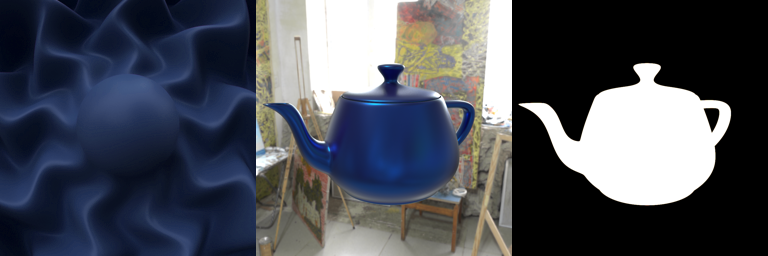

In [14]:
# read image prompt
image = Image.open("assets/images/havran.png").resize((256, 256)) # Condition IP-Adapter (material)
masked_image = Image.open("assets/inpainting/teapot_image.png").resize((256, 256)) # Image to mask
mask = Image.open("assets/inpainting/teapot_mask.png").resize((256, 256)) # Mask
black = Image.open("assets/black.png").resize((256, 256)) # For debugging purposes
image_grid([image, masked_image, mask], 1, 3)

In [15]:
# load ip-adapter
ip_model = IPAdapter(pipe, image_encoder_path, ip_ckpt, device, custom_FVAE=use_custom)

[WARNING] Selecting the following dimensions as relevant.
Make sure this is correct before using them
[ 3  6  7 11 13 17 19]


Image embeds: tensor([[ 3.0835e-01,  1.9257e-02,  3.2926e-04, -1.2561e-01, -9.1858e-03,
          4.0863e-02, -5.9082e-01,  9.7949e-01, -4.0039e-02, -7.8064e-02,
         -1.1530e-01,  4.8071e-01,  7.2876e-02,  6.6650e-01, -3.7048e-02,
         -4.3365e-02,  6.8848e-02, -1.0645e+00,  2.5284e-02,  1.0029e+00]],
       device='cuda:0', dtype=torch.float16)
After filtering the relevant dimensions ([ 3  6  7 11 13 17 19]): tensor([[-0.1256, -0.5908,  0.9795,  0.4807,  0.6665, -1.0645,  1.0029]],
       device='cuda:0', dtype=torch.float16)


100%|██████████| 30/30 [00:02<00:00, 13.67it/s]


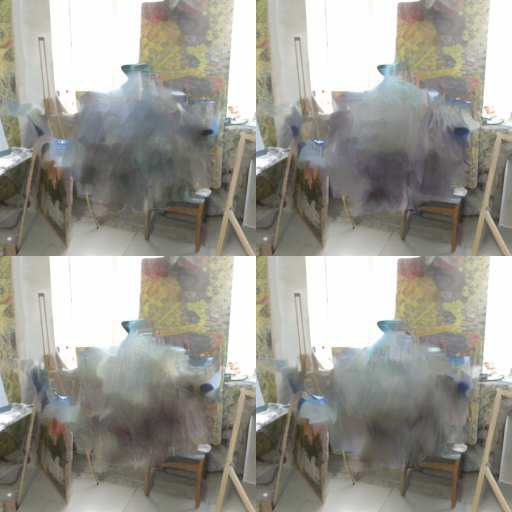

In [16]:
# generate
images = ip_model.generate(pil_image=image, num_samples=4, num_inference_steps=30, control_image=image,
                           seed=42, image=masked_image, mask_image=mask, controlnet_conditioning_scale=0.99 )
grid = image_grid(images, 2,2)
grid

## ControlNet **Depth**

In [17]:
# load controlnet
controlnet_model_path = root_path + "control_v11f1p_sd15_depth"
controlnet = ControlNetModel.from_pretrained(controlnet_model_path, torch_dtype=torch.float16)
# load SD pipeline
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    base_model_path,
    controlnet=controlnet,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00,  6.46it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


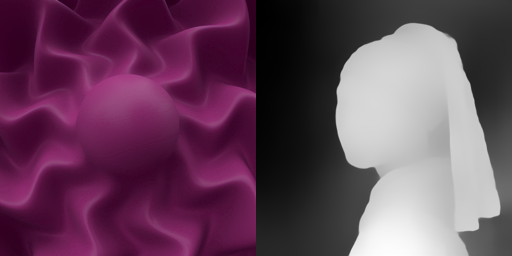

In [18]:
# read image prompt
image = Image.open("assets/images/havran_pink.png") # Condition IP-Adapter
depth_map = Image.open("assets/structure_controls/depth.png") # Condition ControlNet -  Leave this to see what it comes up with~~
image_grid([image.resize((256, 256)), depth_map.resize((256, 256))], 1, 2)

In [19]:
# load ip-adapter
ip_model = IPAdapter(pipe, image_encoder_path, ip_ckpt, device, custom_FVAE=use_custom)

[WARNING] Selecting the following dimensions as relevant.
Make sure this is correct before using them
[ 3  6  7 11 13 17 19]


Image embeds: tensor([[ 1.2422,  0.1237, -0.0672, -0.2688, -0.0219,  0.1058, -0.9229,  0.7954,
         -0.0576, -0.1271, -0.1289,  0.3335,  0.1444,  0.2145, -0.0822,  0.0366,
          0.0767, -1.1387, -0.0133, -1.2393]], device='cuda:0',
       dtype=torch.float16)
After filtering the relevant dimensions ([ 3  6  7 11 13 17 19]): tensor([[-0.2688, -0.9229,  0.7954,  0.3335,  0.2145, -1.1387, -1.2393]],
       device='cuda:0', dtype=torch.float16)


100%|██████████| 30/30 [00:03<00:00,  7.63it/s]


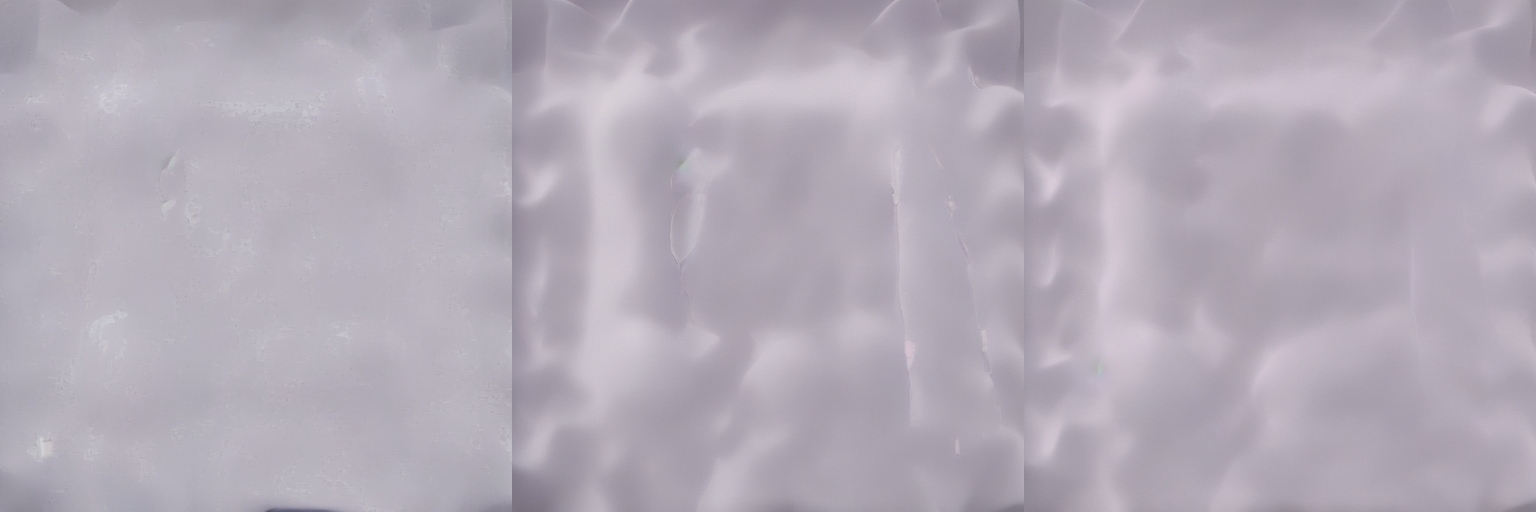

In [20]:
# generate image variations
images = ip_model.generate(pil_image=image, image=depth_map, num_samples=3, num_inference_steps=30, 
                            seed=42, controlnet_conditioning_scale=0.9)
grid = image_grid(images, 1, 3)
grid

## ControlNet Inpainting (with normals)

In [21]:
# load SD pipe
# del pipe, ip_model
torch.cuda.empty_cache()

# load controlnet
controlnet_model_path = root_path + "control_v11p_sd15_normalbae"
controlnet = ControlNetModel.from_pretrained(controlnet_model_path, torch_dtype=torch.float16)
# load SD pipeline
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    base_model_path,
    controlnet=controlnet,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)
pipe.unet = register_cross_attention_hook(pipe.unet) # TODO: Ver qué hace esto

Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00,  6.70it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet_inpaint.StableDiffusionControlNetInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [22]:
# load ip-adapter
ip_model = IPAdapter(pipe, image_encoder_path, ip_ckpt, device, custom_FVAE=use_custom)

[WARNING] Selecting the following dimensions as relevant.
Make sure this is correct before using them
[ 3  6  7 11 13 17 19]


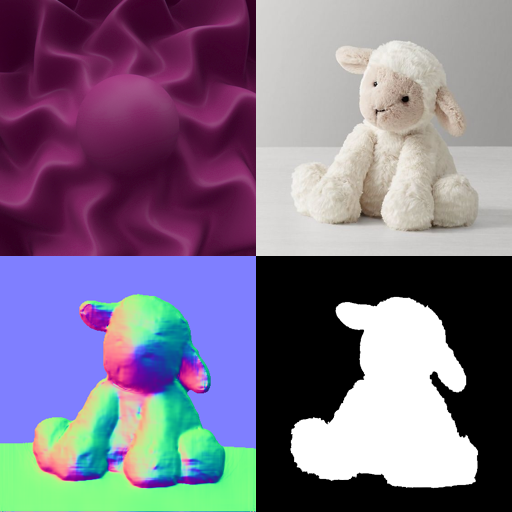

In [23]:
# read image prompt
image = Image.open("assets/images/havran_pink.png")
image.resize((256, 256))
masked_image = Image.open("assets/inpainting/toy_image.jpg").resize((256, 256))
mask = Image.open("assets/inpainting/toy_mask.png").resize((256, 256))
normals = Image.open("assets/inpainting/toy_normals.png").resize((256, 256))
image_grid([image, masked_image, normals, mask], 2,2)

Image embeds: tensor([[ 1.2422,  0.1237, -0.0672, -0.2688, -0.0219,  0.1058, -0.9229,  0.7954,
         -0.0576, -0.1271, -0.1289,  0.3335,  0.1444,  0.2145, -0.0822,  0.0366,
          0.0767, -1.1387, -0.0133, -1.2393]], device='cuda:0',
       dtype=torch.float16)
After filtering the relevant dimensions ([ 3  6  7 11 13 17 19]): tensor([[-0.2688, -0.9229,  0.7954,  0.3335,  0.2145, -1.1387, -1.2393]],
       device='cuda:0', dtype=torch.float16)


100%|██████████| 50/50 [00:03<00:00, 13.47it/s]


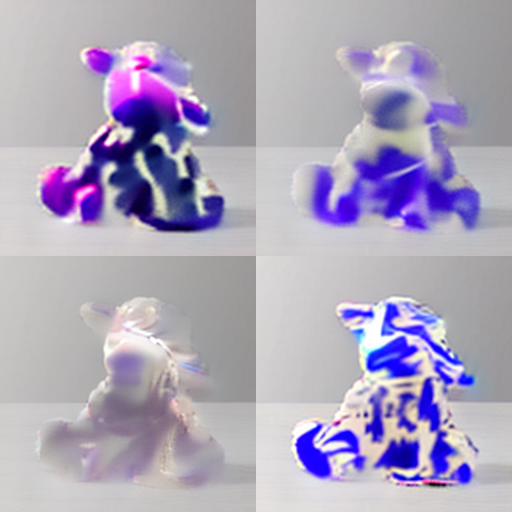

In [24]:
# generate
images = ip_model.generate(pil_image=image, num_samples=4, num_inference_steps=50, control_image=normals,
                           seed=42, image=masked_image, mask_image=mask, controlnet_conditioning_scale=0.9 )
grid = image_grid(images, 2,2)
grid

## ControlNet Inpainting (with **depth**)

In [25]:
# load SD pipe
# del pipe, ip_model
torch.cuda.empty_cache()

# load controlnet
controlnet_model_path = root_path + "control_v11f1p_sd15_depth"
controlnet = ControlNetModel.from_pretrained(controlnet_model_path, torch_dtype=torch.float16)
# load SD pipeline
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    base_model_path,
    controlnet=controlnet,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)
pipe.unet = register_cross_attention_hook(pipe.unet) # TODO: Ver qué hace esto

Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00,  5.50it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet_inpaint.StableDiffusionControlNetInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [26]:
# load ip-adapter
ip_model = IPAdapter(pipe, image_encoder_path, ip_ckpt, device, custom_FVAE=use_custom)

[WARNING] Selecting the following dimensions as relevant.
Make sure this is correct before using them
[ 3  6  7 11 13 17 19]


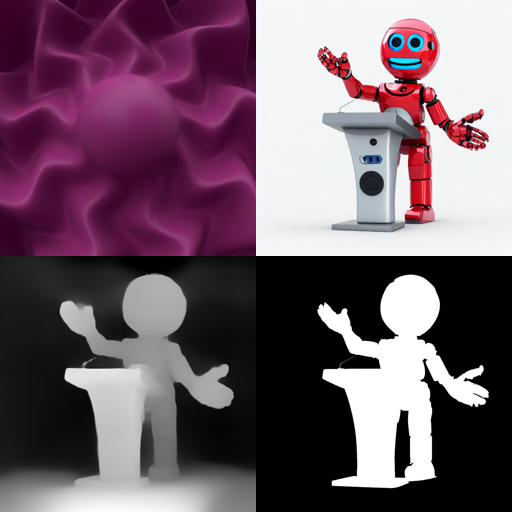

In [27]:
# read image prompt
image = Image.open("assets/images/havran_pink.png")
image.resize((256, 256))
masked_image = Image.open("assets/inpainting/robot_image.png").resize((256, 256))
mask = Image.open("assets/inpainting/robot_mask.png").resize((256, 256))
depth = Image.open("assets/inpainting/robot_depth.png").resize((256, 256))
image_grid([image, masked_image, depth, mask], 2, 2)

Image embeds: tensor([[ 1.2422,  0.1237, -0.0672, -0.2688, -0.0219,  0.1058, -0.9229,  0.7954,
         -0.0576, -0.1271, -0.1289,  0.3335,  0.1444,  0.2145, -0.0822,  0.0366,
          0.0767, -1.1387, -0.0133, -1.2393]], device='cuda:0',
       dtype=torch.float16)
After filtering the relevant dimensions ([ 3  6  7 11 13 17 19]): tensor([[-0.2688, -0.9229,  0.7954,  0.3335,  0.2145, -1.1387, -1.2393]],
       device='cuda:0', dtype=torch.float16)


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:03<00:00, 12.86it/s]


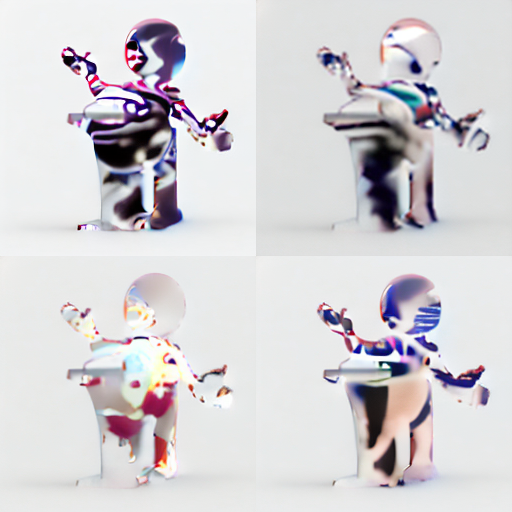

In [28]:
# generate
images = ip_model.generate(pil_image=image, num_samples=4, num_inference_steps=50, control_image=depth,
                           seed=42, image=masked_image, mask_image=mask, controlnet_conditioning_scale=0.9, 
                        #    prompt="a yellow robot giving a speech, good quality, professional camera, HDR"
                           )
grid = image_grid(images, 2,2)
grid

## ZeST setup

In [2]:
from ip_adapter import IPAdapterXL
root_path = "/media/raid/santiagojn/IPAdapter/"

base_model_path = root_path + "stable-diffusion-xl-base-1.0"
image_encoder_path = root_path + "models/image_encoder" #? weird that it doesn't use the image encoders from SD XL?
ip_ckpt = root_path + "sdxl_models/ip-adapter_sdxl_vit-h.bin"
controlnet_path = root_path + "controlnet-depth-sdxl-1.0"
device = "cuda"

In [3]:
torch.cuda.empty_cache()

# load SD pipeline
controlnet = ControlNetModel.from_pretrained(controlnet_path, variant="fp16", use_safetensors=True, torch_dtype=torch.float16).to(device)
pipe = StableDiffusionXLControlNetInpaintPipeline.from_pretrained(
    base_model_path,
    controlnet=controlnet,
    use_safetensors=True,
    torch_dtype=torch.float16,
    add_watermarker=False,
).to(device)
pipe.unet = register_cross_attention_hook(pipe.unet)

ip_model = IPAdapterXL(pipe, image_encoder_path, ip_ckpt, device)

Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  1.86it/s]


In [4]:
obj = 'cylinder'
texture = 'plate'
target_image_path = '/home/santiagojn/IP-Adapter/assets/demo_assets_zest/input_imgs/' + obj + '.png'  # Replace with your image path
target_image = Image.open(target_image_path).convert('RGB')
rm_bg = remove(target_image)
# output.save(output_path)
target_mask = rm_bg.convert("RGB").point(lambda x: 0 if x < 3 else 255).convert('L').convert('RGB')# Convert mask to grayscale

# Ensure mask is the same size as image

# mask = ImageChops.invert(mask)
# Generate random noise for the size of the image
noise = np.random.randint(0, 256, target_image.size + (3,), dtype=np.uint8)
noise_image = Image.fromarray(noise)
mask_target_img = ImageChops.lighter(target_image, target_mask)
invert_target_mask = ImageChops.invert(target_mask)

In [5]:
from PIL import ImageEnhance
gray_target_image = target_image.convert('L').convert('RGB')
gray_target_image = ImageEnhance.Brightness(gray_target_image)

# Adjust brightness
# The factor 1.0 means original brightness, greater than 1.0 makes the image brighter. Adjust this if the image is too dim
factor = 1.0  # Try adjusting this to get the desired brightness

gray_target_image = gray_target_image.enhance(factor)
grayscale_img = ImageChops.darker(gray_target_image, target_mask)
img_black_mask = ImageChops.darker(target_image, invert_target_mask)
grayscale_init_img = ImageChops.lighter(img_black_mask, grayscale_img)
init_img = grayscale_init_img

ip_image = Image.open("/home/santiagojn/IP-Adapter/assets/demo_assets_zest/material_exemplars/" + texture + ".png")

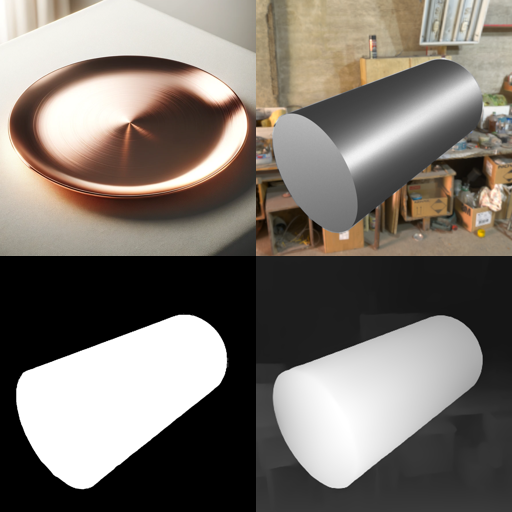

In [6]:
np_image = np.array(Image.open('/home/santiagojn/IP-Adapter/assets/demo_assets_zest/depths/' + obj + '.png'))
np_image = (np_image / 256).astype('uint8')

depth_map = Image.fromarray(np_image).resize((1024,1024))

init_img = init_img.resize((1024,1024))
mask = target_mask.resize((1024, 1024))
# grid = image_grid([target_mask.resize((256, 256)), ip_image.resize((256, 256)), init_img.resize((256, 256)), depth_map.resize((256, 256))], 1, 4)
grid = image_grid([ip_image.resize((256, 256)), init_img.resize((256, 256)), target_mask.resize((256, 256)), depth_map.resize((256, 256))], 2,2)

# Visualize each input individually
grid

In [7]:
num_samples = 4
# print(f'mask shape: {np.array(mask).shape}')
# mask = np.expand_dims(np.array(mask), axis=0) # ! Si hay una dimensión inicial [1,...], luego hay problemas con operaciones matriciales (razón?)
print(f'mask shape: {np.array(mask).shape}')
images = ip_model.generate(pil_image=ip_image, image=init_img, control_image=depth_map, 
    mask_image=mask, controlnet_conditioning_scale=0.9, num_samples=num_samples, num_inference_steps=30, seed=42,)

grid = image_grid(images, 2,2)
grid

mask shape: (1024, 1024, 3)
Image embeds with CLIP: 
tensor([[ 0.1730,  0.2832, -0.5039,  ..., -0.2771, -0.0790,  0.3625]],
       device='cuda:0', dtype=torch.float16)
Before preparing mask. mask_image: (1024, 1024, 3)
After preparing mask. mask: torch.Size([1, 1, 1024, 1024])
Before preparing mask latents
	mask: torch.Size([1, 1, 1024, 1024])
XL++++Function prepare_mask_latents. Inputs:
	mask: torch.Size([1, 1, 1024, 1024])
	masked_image: torch.Size([1, 3, 1024, 1024])
After _interpolating_. mask: torch.Size([1, 1, 128, 128])
After preparing mask latents
	mask: torch.Size([8, 1, 128, 128])
	masked_image_latents: torch.Size([8, 4, 128, 128])


  3%|▎         | 1/29 [00:01<00:38,  1.37s/it]

Mask before chunking: torch.Size([8, 1, 128, 128])
-----Inside the __call__ function of XL pipeline-----
	init_mask: torch.Size([4, 1, 128, 128])
	init_latents_proper: torch.Size([4, 4, 128, 128])
	latents: torch.Size([4, 4, 128, 128])
Mask before chunking: torch.Size([8, 1, 128, 128])


  7%|▋         | 2/29 [00:02<00:32,  1.20s/it]

-----Inside the __call__ function of XL pipeline-----
	init_mask: torch.Size([4, 1, 128, 128])
	init_latents_proper: torch.Size([4, 4, 128, 128])
	latents: torch.Size([4, 4, 128, 128])
Mask before chunking: torch.Size([8, 1, 128, 128])


 10%|█         | 3/29 [00:04<00:36,  1.39s/it]

-----Inside the __call__ function of XL pipeline-----
	init_mask: torch.Size([4, 1, 128, 128])
	init_latents_proper: torch.Size([4, 4, 128, 128])
	latents: torch.Size([4, 4, 128, 128])
Mask before chunking: torch.Size([8, 1, 128, 128])


 14%|█▍        | 4/29 [00:06<00:43,  1.75s/it]

-----Inside the __call__ function of XL pipeline-----
	init_mask: torch.Size([4, 1, 128, 128])
	init_latents_proper: torch.Size([4, 4, 128, 128])
	latents: torch.Size([4, 4, 128, 128])
Mask before chunking: torch.Size([8, 1, 128, 128])


 17%|█▋        | 5/29 [00:08<00:46,  1.96s/it]

-----Inside the __call__ function of XL pipeline-----
	init_mask: torch.Size([4, 1, 128, 128])
	init_latents_proper: torch.Size([4, 4, 128, 128])
	latents: torch.Size([4, 4, 128, 128])
Mask before chunking: torch.Size([8, 1, 128, 128])


 21%|██        | 6/29 [00:11<00:47,  2.08s/it]

-----Inside the __call__ function of XL pipeline-----
	init_mask: torch.Size([4, 1, 128, 128])
	init_latents_proper: torch.Size([4, 4, 128, 128])
	latents: torch.Size([4, 4, 128, 128])
Mask before chunking: torch.Size([8, 1, 128, 128])


 24%|██▍       | 7/29 [00:13<00:47,  2.15s/it]

-----Inside the __call__ function of XL pipeline-----
	init_mask: torch.Size([4, 1, 128, 128])
	init_latents_proper: torch.Size([4, 4, 128, 128])
	latents: torch.Size([4, 4, 128, 128])
Mask before chunking: torch.Size([8, 1, 128, 128])


 28%|██▊       | 8/29 [00:15<00:46,  2.21s/it]

-----Inside the __call__ function of XL pipeline-----
	init_mask: torch.Size([4, 1, 128, 128])
	init_latents_proper: torch.Size([4, 4, 128, 128])
	latents: torch.Size([4, 4, 128, 128])
Mask before chunking: torch.Size([8, 1, 128, 128])


 31%|███       | 9/29 [00:17<00:44,  2.24s/it]

-----Inside the __call__ function of XL pipeline-----
	init_mask: torch.Size([4, 1, 128, 128])
	init_latents_proper: torch.Size([4, 4, 128, 128])
	latents: torch.Size([4, 4, 128, 128])
Mask before chunking: torch.Size([8, 1, 128, 128])


 34%|███▍      | 10/29 [00:20<00:43,  2.27s/it]

-----Inside the __call__ function of XL pipeline-----
	init_mask: torch.Size([4, 1, 128, 128])
	init_latents_proper: torch.Size([4, 4, 128, 128])
	latents: torch.Size([4, 4, 128, 128])
Mask before chunking: torch.Size([8, 1, 128, 128])


 38%|███▊      | 11/29 [00:22<00:41,  2.28s/it]

-----Inside the __call__ function of XL pipeline-----
	init_mask: torch.Size([4, 1, 128, 128])
	init_latents_proper: torch.Size([4, 4, 128, 128])
	latents: torch.Size([4, 4, 128, 128])
Mask before chunking: torch.Size([8, 1, 128, 128])


 41%|████▏     | 12/29 [00:24<00:38,  2.29s/it]

-----Inside the __call__ function of XL pipeline-----
	init_mask: torch.Size([4, 1, 128, 128])
	init_latents_proper: torch.Size([4, 4, 128, 128])
	latents: torch.Size([4, 4, 128, 128])
Mask before chunking: torch.Size([8, 1, 128, 128])


 45%|████▍     | 13/29 [00:27<00:36,  2.30s/it]

-----Inside the __call__ function of XL pipeline-----
	init_mask: torch.Size([4, 1, 128, 128])
	init_latents_proper: torch.Size([4, 4, 128, 128])
	latents: torch.Size([4, 4, 128, 128])
Mask before chunking: torch.Size([8, 1, 128, 128])


 48%|████▊     | 14/29 [00:29<00:34,  2.31s/it]

-----Inside the __call__ function of XL pipeline-----
	init_mask: torch.Size([4, 1, 128, 128])
	init_latents_proper: torch.Size([4, 4, 128, 128])
	latents: torch.Size([4, 4, 128, 128])
Mask before chunking: torch.Size([8, 1, 128, 128])


 52%|█████▏    | 15/29 [00:31<00:32,  2.32s/it]

-----Inside the __call__ function of XL pipeline-----
	init_mask: torch.Size([4, 1, 128, 128])
	init_latents_proper: torch.Size([4, 4, 128, 128])
	latents: torch.Size([4, 4, 128, 128])
Mask before chunking: torch.Size([8, 1, 128, 128])


 55%|█████▌    | 16/29 [00:34<00:30,  2.33s/it]

-----Inside the __call__ function of XL pipeline-----
	init_mask: torch.Size([4, 1, 128, 128])
	init_latents_proper: torch.Size([4, 4, 128, 128])
	latents: torch.Size([4, 4, 128, 128])
Mask before chunking: torch.Size([8, 1, 128, 128])


 59%|█████▊    | 17/29 [00:36<00:27,  2.33s/it]

-----Inside the __call__ function of XL pipeline-----
	init_mask: torch.Size([4, 1, 128, 128])
	init_latents_proper: torch.Size([4, 4, 128, 128])
	latents: torch.Size([4, 4, 128, 128])
Mask before chunking: torch.Size([8, 1, 128, 128])


 62%|██████▏   | 18/29 [00:38<00:25,  2.33s/it]

-----Inside the __call__ function of XL pipeline-----
	init_mask: torch.Size([4, 1, 128, 128])
	init_latents_proper: torch.Size([4, 4, 128, 128])
	latents: torch.Size([4, 4, 128, 128])
Mask before chunking: torch.Size([8, 1, 128, 128])


 66%|██████▌   | 19/29 [00:41<00:23,  2.33s/it]

-----Inside the __call__ function of XL pipeline-----
	init_mask: torch.Size([4, 1, 128, 128])
	init_latents_proper: torch.Size([4, 4, 128, 128])
	latents: torch.Size([4, 4, 128, 128])
Mask before chunking: torch.Size([8, 1, 128, 128])


 69%|██████▉   | 20/29 [00:43<00:21,  2.33s/it]

-----Inside the __call__ function of XL pipeline-----
	init_mask: torch.Size([4, 1, 128, 128])
	init_latents_proper: torch.Size([4, 4, 128, 128])
	latents: torch.Size([4, 4, 128, 128])
Mask before chunking: torch.Size([8, 1, 128, 128])


 72%|███████▏  | 21/29 [00:45<00:18,  2.33s/it]

-----Inside the __call__ function of XL pipeline-----
	init_mask: torch.Size([4, 1, 128, 128])
	init_latents_proper: torch.Size([4, 4, 128, 128])
	latents: torch.Size([4, 4, 128, 128])
Mask before chunking: torch.Size([8, 1, 128, 128])


 76%|███████▌  | 22/29 [00:48<00:16,  2.33s/it]

-----Inside the __call__ function of XL pipeline-----
	init_mask: torch.Size([4, 1, 128, 128])
	init_latents_proper: torch.Size([4, 4, 128, 128])
	latents: torch.Size([4, 4, 128, 128])
Mask before chunking: torch.Size([8, 1, 128, 128])


 79%|███████▉  | 23/29 [00:50<00:14,  2.34s/it]

-----Inside the __call__ function of XL pipeline-----
	init_mask: torch.Size([4, 1, 128, 128])
	init_latents_proper: torch.Size([4, 4, 128, 128])
	latents: torch.Size([4, 4, 128, 128])
Mask before chunking: torch.Size([8, 1, 128, 128])


 83%|████████▎ | 24/29 [00:52<00:11,  2.34s/it]

-----Inside the __call__ function of XL pipeline-----
	init_mask: torch.Size([4, 1, 128, 128])
	init_latents_proper: torch.Size([4, 4, 128, 128])
	latents: torch.Size([4, 4, 128, 128])
Mask before chunking: torch.Size([8, 1, 128, 128])


 86%|████████▌ | 25/29 [00:55<00:09,  2.34s/it]

-----Inside the __call__ function of XL pipeline-----
	init_mask: torch.Size([4, 1, 128, 128])
	init_latents_proper: torch.Size([4, 4, 128, 128])
	latents: torch.Size([4, 4, 128, 128])
Mask before chunking: torch.Size([8, 1, 128, 128])


 90%|████████▉ | 26/29 [00:57<00:07,  2.34s/it]

-----Inside the __call__ function of XL pipeline-----
	init_mask: torch.Size([4, 1, 128, 128])
	init_latents_proper: torch.Size([4, 4, 128, 128])
	latents: torch.Size([4, 4, 128, 128])
Mask before chunking: torch.Size([8, 1, 128, 128])


 93%|█████████▎| 27/29 [00:59<00:04,  2.34s/it]

-----Inside the __call__ function of XL pipeline-----
	init_mask: torch.Size([4, 1, 128, 128])
	init_latents_proper: torch.Size([4, 4, 128, 128])
	latents: torch.Size([4, 4, 128, 128])
Mask before chunking: torch.Size([8, 1, 128, 128])


 97%|█████████▋| 28/29 [01:02<00:02,  2.34s/it]

-----Inside the __call__ function of XL pipeline-----
	init_mask: torch.Size([4, 1, 128, 128])
	init_latents_proper: torch.Size([4, 4, 128, 128])
	latents: torch.Size([4, 4, 128, 128])


100%|██████████| 29/29 [01:04<00:00,  2.21s/it]

Mask before chunking: torch.Size([8, 1, 128, 128])
-----Inside the __call__ function of XL pipeline-----
	init_mask: torch.Size([4, 1, 128, 128])
	init_latents_proper: torch.Size([4, 4, 128, 128])
	latents: torch.Size([4, 4, 128, 128])


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 GiB. GPU 0 has a total capacity of 47.54 GiB of which 1.62 GiB is free. Process 404274 has 29.60 GiB memory in use. Process 446584 has 1.74 GiB memory in use. Including non-PyTorch memory, this process has 14.30 GiB memory in use. Process 401950 has 260.00 MiB memory in use. Of the allocated memory 12.48 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)